# Feature Importance

Feature selection or dimensionality reduction can help to improve estimator's predictive power or to boost their performance on high dimensional data. One feature selection strategy is to select the k best features from a dataset, where 'best' means that they contribute the most to a predictor's decision. This is what feature importance stands for.

In this notebook I will demonstrate how you can retrieve feature importances from a tree based estimator like Random Forest. And how these then can form the foundation of your feature selection strategy.

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

For simple illustration, we will work with the [Boston Housing Dataset](cs.toronto.edu/~delve/data/boston/bostonDetail.html) in this notebook.

In [38]:
# Load boston housing data
data = load_boston()
data = pd.DataFrame(np.c_[data.data, data.target], columns=data.feature_names.tolist()+['label'])
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,label
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


First, let's train a `RandomForestRegressor` to predict the median price of a home.

In [39]:
# Get train test split
X, y = data.drop('label', axis=1), data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Fit the model
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

We can access the importance of our features using the `.feature_importances_` attribute of the fitted model.

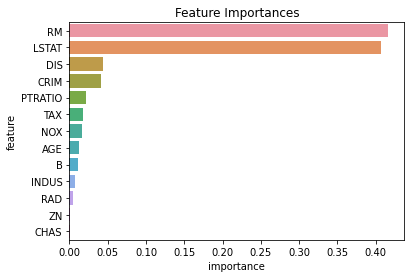

In [40]:
# Put feature importances into dataframe
feature_importance = pd.DataFrame({
    'feature': X_train.columns, 
    'importance': rf.feature_importances_}
)

# Plot feature importances barplot
fig, ax = plt.subplots()
ax.set_title("Feature Importances")
sns.barplot(
    x='importance', y='feature', 
    data=feature_importance.sort_values('importance', ascending=False),
    ax=ax
)
plt.show()

With that, we can basically choose between two feature selection strategies:
1. We choose only the top `k` features. 
2. We choose only features with a feature importance score greater than some threshold.

Here, we will take the second approach and consider features only if their importance score is greater than `.01`. Instead of performing this step by hand, we will use a `SelectFromModel` transformer since it is very convenient for using in pipelines (which I will show at the end of this notebook).

In [42]:
# Initialize the transformer object
selector = SelectFromModel(rf, prefit=True, threshold=.01)

# Put feature importances and selection decision into dataframe
pd.DataFrame({'feature': X_train.columns,
              'importance': rf.feature_importances_,
              'selection': selector.get_support()})

,feature,importance,selection
0,CRIM,0.041545,True
1,ZN,0.001119,False
2,INDUS,0.006865,False
3,CHAS,0.000650,False
4,NOX,0.015836,True
5,RM,0.416495,True
6,AGE,0.012385,True
7,DIS,0.043280,True
8,RAD,0.004085,False
9,TAX,0.018018,True


With that, we can retrain our model on the reduced feature set. It gives us an out-of-sample RMSE of 4.12.

In [34]:
# Fit the model with reduced feature set
X_train_new, X_test_new = selector.transform(X_train), selector.transform(X_test)
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train_new, y_train)

# Evaluate predictions on the test set
preds = rf.predict(X_test_new)
print("RMSE: {:.2f}".format(mean_squared_error(y_test, preds, squared=False)))

RMSE: 4.12


And here is how you can wrap the whole procedure into a sklearn pipeline:

In [35]:
# Fit the pipeline
pipeline = Pipeline([
    ('selector', SelectFromModel(RandomForestRegressor(random_state=0), threshold=.01)),
    ('rf', RandomForestRegressor(random_state=0))
])
pipeline.fit(X_train, y_train)

# Evaluate predictions on the test set
preds = pipeline.predict(X_test)
print("RMSE: {:.2f}".format(mean_squared_error(y_test, preds, squared=False)))

RMSE: 4.12
